In [1]:
import sys, os, copy, re
import pandas as pd
import seaborn as sns
from scipy.optimize import newton, minimize, fsolve
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [2]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=0.9)
cmap = sns.color_palette()

In [3]:
def RR2Asp(RR):
    return(54.863* (RR**1.0646))
def RR2Asn(RR):
    return(60.033* (RR**0.9177))

In [4]:
### Read measurements

annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('HCT116_Metformin_Asp-level.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['ISTD Response']) != 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']

        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['dilution']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

In [5]:
# metab_names_mes

In [6]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values

In [7]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)

In [8]:
df_mean = df.groupby(['Metformin', 'Treatment']).mean(numeric_only=True).reset_index()
df_stdev = df.groupby(['Metformin', 'Treatment']).std(numeric_only=True).reset_index()
df_stdev['Prlfr'] = df_mean['Prlfr_stdev']
df_stdev['Prlfr'] = df_mean['Prlfr_stdev']

In [9]:
def sig_fit(x, top, midpoint, bottom, slope):
    return(top + (bottom - top) / (1 + (x / midpoint)**slope))

def x_XX(top, midpoint, bottom, slope, XX):
    #print(midpoint)
    #print(slope)
    yXX = (top - bottom)*(100-XX)/100 + bottom
    mid = (midpoint * ((top - yXX) / (yXX - bottom))**(1.0 / slope))
    return(mid)

def sig_fit_loss(mes_y, x, top, bottom, p):
    pred_y = sig_fit(x, top, p[0], bottom, p[1])
    return(sum((mes_y-pred_y)**2))

def fit_sigmoid(x, y , percentiles, Ngrid, top, bottom):
    bnds = ((1e-4, None), (1e-1, 1e4))
    def fun_sig_fit(p): return(sig_fit_loss(y, x, top, bottom, p))
    p_sig_fit = minimize(fun_sig_fit, (500, 1), method='L-BFGS-B', bounds=bnds)
    midpoint, slope = p_sig_fit.x
    # print(slope)
    # print(p_sig_fit.fun)

    x_lower = x_XX(top, midpoint, bottom, slope, percentiles[0])
    x_upper = x_XX(top, midpoint, bottom, slope, percentiles[1])
    x_sig = np.logspace(np.log10(x_lower), np.log10(x_upper), Ngrid, base=10)
    y_sig = sig_fit(x_sig, top, midpoint, bottom, slope)
    x50 = x_XX(top, midpoint, bottom, slope, 50)
    
    return(x_sig, y_sig, x50)

def plot_sigmoid(df_mean, ax1, top, mask, bottom=0, col='Aspartate conc', \
                 percentile=(1, 99), plt_mid=False, color='gray'):

    x = df[mask][col].values
    y = df[mask]['Prlfr'].values
    
    x_sig, y_sig, x50 = fit_sigmoid(x, y, percentile, 1000, top, bottom)
    ax1.plot(x_sig, y_sig, '--', linewidth=3, color=color)
    
    print(x50)
    if plt_mid:
        ax1.vlines(x50, bottom, top, ls='--', color='r')
        halfmax = round(x50)
        anno_str = 'Asp half-max\n{} μM'.format(halfmax)
        props = dict(boxstyle='round', alpha=1, \
                     ec=(1., 0.5, 0.5), \
                     fc=(1., 0.8, 0.8), \
                     )
        if percentile[1] < 96:
            ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                     va="top", multialignment='center', \
                     bbox=props)
        else:
            ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                     va="top", multialignment='center', \
                     bbox=props)
    return(x_sig, y_sig, x50, bottom, top)

285.51438711831025
534.6148346227308


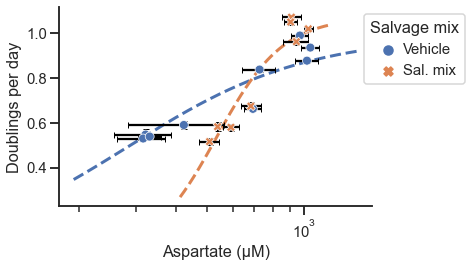

In [10]:
### Proliferation rate as a function of Aspartate ###

col='Aspartate conc'
order = ['Vehicle', 'Sal. mix']


fig = plt.figure(figsize=(6.8, 4))
mask1 = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
g = sns.scatterplot(data=df_mean[mask1], x=col, y='Prlfr', hue='Treatment',
             style='Treatment', markers=True, zorder=11, s=80, hue_order=order, style_order=order)
g.errorbar(y=df_mean[mask1]['Prlfr'].values, x=df_mean[mask1][col].values, xerr=df_stdev[mask1][col].values, yerr=df_stdev[mask1]['Prlfr'].values, fmt='none', color='black', capsize=3, zorder=10)

g.set(xscale="log");
#g.set(xlim=(60, 10000))
#g.set(ylim=(0.25, 1.2))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())

plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);


top_i = [93, 97]
bottom_i = [35, 25]
for ci, sal_tr in enumerate(order):
    mask1 = (df_mean['Treatment'] == sal_tr)
    top = df_mean[mask1]['Prlfr'].max()
    mask = (df['Treatment'] == sal_tr)
    x_sig, y_sig, x50, bottom, top = plot_sigmoid(df_mean, g, top, mask, col=col, \
                                                  percentile=(bottom_i[ci], top_i[ci]), color=cmap[ci])


sns.despine()


plt.legend(bbox_to_anchor=(0.95, 1), loc="upper left", title='Salvage mix', handletextpad=0)#, fontsize=15, title_fontsize=15)
plt.tight_layout()

fig.savefig('HCT116_Met_Asp_vs_prlfr.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)


22.075591962960342
29.646084584185328


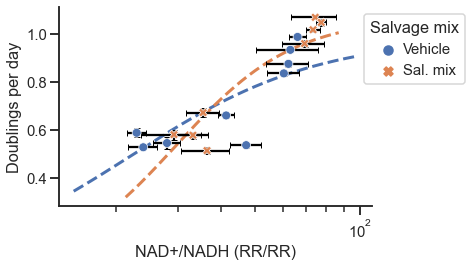

In [11]:
### Proliferation rate as a function of Aspartate ###

col='NAD-NADH'
order = ['Vehicle', 'Sal. mix']


fig = plt.figure(figsize=(6.8, 4))
mask1 = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
g = sns.scatterplot(data=df_mean[mask1], x=col, y='Prlfr', hue='Treatment',
             style='Treatment', markers=True, zorder=11, s=80, hue_order=order, style_order=order)
g.errorbar(y=df_mean[mask1]['Prlfr'].values, x=df_mean[mask1][col].values, xerr=df_stdev[mask1][col].values, yerr=df_stdev[mask1]['Prlfr'].values, fmt='none', color='black', capsize=3, zorder=10)

g.set(xscale="log");
#g.set(xlim=(60, 10000))
#g.set(ylim=(0.25, 1.2))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())

plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('NAD+/NADH (RR/RR)')#, size=12);


top_i = [92, 94]
bottom_i = [35, 30]
for ci, sal_tr in enumerate(order):
    mask1 = (df_mean['Treatment'] == sal_tr)
    top = df_mean[mask1]['Prlfr'].max()
    mask = (df['Treatment'] == sal_tr)
    x_sig, y_sig, x50, bottom, top = plot_sigmoid(df_mean, g, top, mask, col=col, \
                                                  percentile=(bottom_i[ci], top_i[ci]), color=cmap[ci])


sns.despine()


plt.legend(bbox_to_anchor=(0.95, 1), loc="upper left", title='Salvage mix', handletextpad=0)#, fontsize=15, title_fontsize=15)
plt.tight_layout()

fig.savefig('HCT116_Met_NAD_vs_prlfr.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)


In [12]:
def sig_fit_rv(x, top, midpoint, bottom, slope):
    return(bottom + (top - bottom) / (1 + (x / midpoint)**slope))

def x_XX_rv(top, midpoint, bottom, slope, XX):
    #print(midpoint)
    #print(slope)
    yXX = (top - bottom)*(100-XX)/100 + bottom
    mid = (midpoint * ((bottom - yXX) / (yXX - top))**(1.0 / slope))

    return(mid)

def sig_fit_loss_rv(mes_y, x, top, bottom, p):
    pred_y = sig_fit_rv(x, top, p[0], bottom, p[1])
    return(sum((mes_y-pred_y)**2))

def fit_sigmoid_rv(x, y , percentiles, Ngrid, top, bottom):
    bnds = ((1e-4, None), (1e-1, 1e4))
    def fun_sig_fit_rv(p): return(sig_fit_loss_rv(y, x, top, bottom, p))
    p_sig_fit = minimize(fun_sig_fit_rv, (500, 1), method='L-BFGS-B', bounds=bnds)
    midpoint, slope = p_sig_fit.x
    # print(slope)
    # print(p_sig_fit.fun)

    x_lower = x_XX_rv(top, midpoint, bottom, slope, percentiles[0])
    x_upper = x_XX_rv(top, midpoint, bottom, slope, percentiles[1])
    x_sig = np.logspace(np.log10(x_lower), np.log10(x_upper), Ngrid, base=10)
    y_sig = sig_fit_rv(x_sig, top, midpoint, bottom, slope)
    x50 = x_XX_rv(top, midpoint, bottom, slope, 50)
    
    return(x_sig, y_sig, x50)

def plot_sigmoid_rv(df_mean, ax1, top, mask, bottom=0, col='Aspartate conc', \
                 percentile=(1, 99), plt_mid=False, color='gray'):

    x = df[mask][col].values
    y = df[mask]['Prlfr'].values
    
    x_sig, y_sig, x50 = fit_sigmoid_rv(x, y, percentile, 1000, top, bottom)
    ax1.plot(x_sig, y_sig, '--', linewidth=3, color=color)
    
    print(x50)
    if plt_mid:
        ax1.vlines(x50, bottom, top, ls='--', color='r')
        halfmax = round(x50)
        anno_str = 'Asp half-max\n{} μM'.format(halfmax)
        props = dict(boxstyle='round', alpha=1, \
                     ec=(1., 0.5, 0.5), \
                     fc=(1., 0.8, 0.8), \
                     )
        if percentile[1] < 96:
            ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                     va="top", multialignment='center', \
                     bbox=props)
        else:
            ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                     va="top", multialignment='center', \
                     bbox=props)
    return(x_sig, y_sig, x50, bottom, top)

In [13]:
df.loc[(df['Metformin'] == 0), 'Metformin'] = 20
df_mean.loc[(df_mean['Metformin'] == 0), 'Metformin'] = 20

808.5535253875687
735.9920998327865


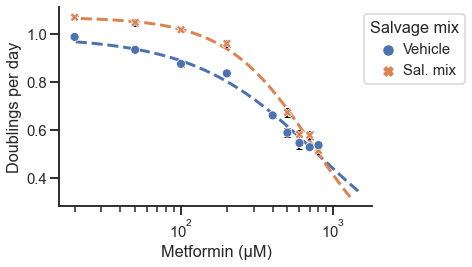

In [15]:
### Proliferation rate as a function of Aspartate ###

col='Metformin'
order = ['Vehicle', 'Sal. mix']


fig = plt.figure(figsize=(6.8, 4))
mask1 = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
g = sns.scatterplot(data=df_mean[mask1], x=col, y='Prlfr', hue='Treatment',
             style='Treatment', markers=True, zorder=11, s=80, hue_order=order, style_order=order)
g.errorbar(y=df_mean[mask1]['Prlfr'].values, x=df_mean[mask1][col].values, yerr=df_stdev[mask1]['Prlfr'].values, fmt='none', color='black', capsize=3, zorder=10)

g.set(xscale="log");
#g.set(xlim=(60, 10000))
#g.set(ylim=(0.25, 1.2))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())

plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('Metformin (µM)')#, size=12);


top_i = [98, 99.5]
bottom_i = [35, 30]
for ci, sal_tr in enumerate(order):
    mask1 = (df_mean['Treatment'] == sal_tr)
    top = df_mean[mask1]['Prlfr'].max()
    mask = (df['Treatment'] == sal_tr)
    x_sig, y_sig, x50, bottom, top = plot_sigmoid_rv(df_mean, g, top, mask, col=col, \
                                                  percentile=(bottom_i[ci], top_i[ci]), color=cmap[ci])


sns.despine()


plt.legend(bbox_to_anchor=(0.95, 1), loc="upper left", title='Salvage mix', handletextpad=0)#, fontsize=15, title_fontsize=15)
plt.tight_layout()

fig.savefig('HCT116_Met_Met_vs_prlfr.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)


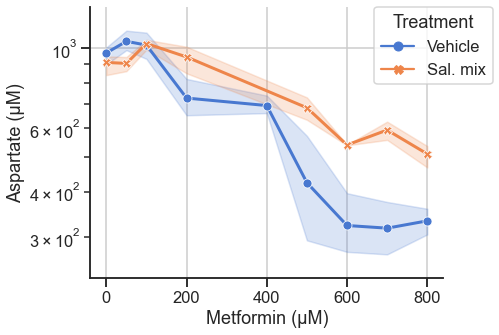

In [10]:
### Aspartate as a function of Metformin ###

fig, ax1 = plt.subplots(1, 1, figsize=(7.4, 5))

mask = ((df['Treatment'] == 'Vehicle') | (df['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df[mask], x='Metformin', y='Aspartate conc', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.set(yscale="log")

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Aspartate (μM)')
g1.set(ylim=(230, 1300))

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.14, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Metformin-Aspartate.pdf', bbox_inches='tight')

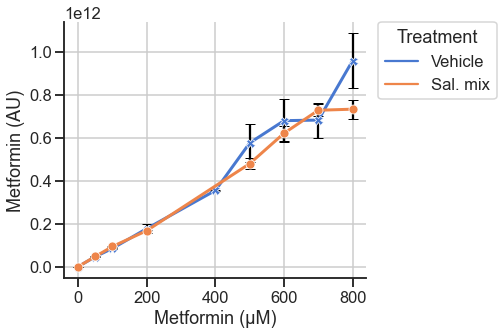

In [10]:
### Aspartate as a function of Metformin ###

fig, ax1 = plt.subplots(1, 1, figsize=(7.4, 5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Metformin', y='Metformin pos', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3)
g1.errorbar(y=df_mean[mask]['Metformin pos'].values, x=df_mean[mask]['Metformin'].values, yerr=df_stdev[mask]['Metformin pos'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Metformin (μM)')
g1.set_ylabel('Metformin (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Metformin-Metformin_pos.pdf', bbox_inches='tight')

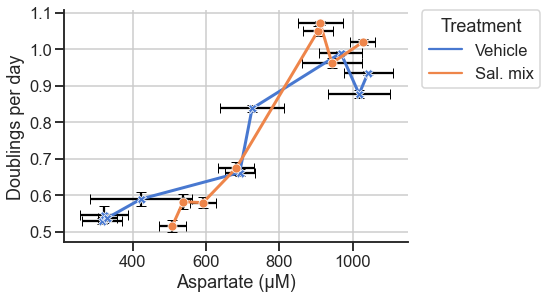

In [11]:
### Proliferation as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)


g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Prlfr.pdf', bbox_inches='tight')

In [20]:
df_mean['Metformin']

0       0
1       0
2      50
3      50
4     100
5     100
6     200
7     200
8     400
9     500
10    500
11    600
12    600
13    700
14    700
15    800
16    800
Name: Metformin, dtype: int64

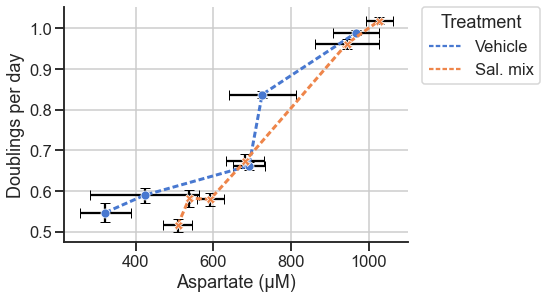

In [21]:
### Proliferation as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Sal. mix') & (df_mean['Metformin'] > 60)) |\
 ((df_mean['Treatment'] == 'Vehicle') & (df_mean['Metformin'] != 50) & (df_mean['Metformin'] != 100) & (df_mean['Metformin'] != 800) & (df_mean['Metformin'] != 700))

hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=[(2, 1), (2, 1)], linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Prlfr_FNT.pdf', bbox_inches='tight')

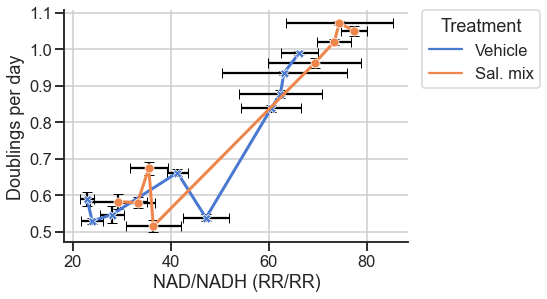

In [12]:
### Proliferation as a function of NAD/NADH ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='NAD-NADH', y='Prlfr', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Prlfr'].values, x=df_mean[mask]['NAD-NADH'].values, yerr=df_stdev[mask]['Prlfr'].values, xerr=df_stdev[mask]['NAD-NADH'].values, fmt='none', color='black', capsize=5, zorder=1)


g1.set_xlabel('NAD/NADH (RR/RR)')
g1.set_ylabel('Doublings per day')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/NAD-NADH-Prlfr.pdf', bbox_inches='tight')

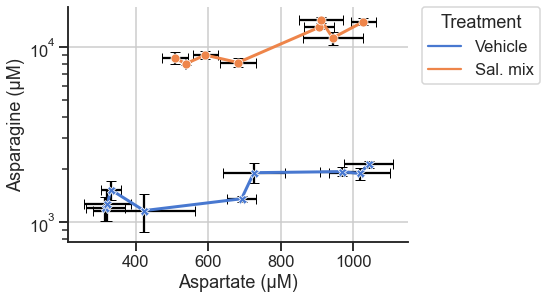

In [10]:
### Asparagine as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Asparagine conc', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Asparagine conc'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Asparagine conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)
#g1.set(yscale="log")

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Asparagine (μM)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Asparagine.pdf', bbox_inches='tight')

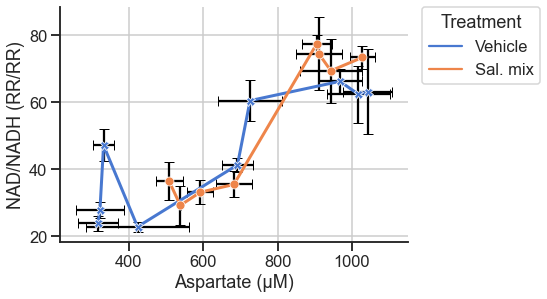

In [26]:
### NAD/NADH as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='NAD-NADH', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['NAD-NADH'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['NAD-NADH'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('NAD/NADH (RR/RR)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-NAD-NADH.pdf', bbox_inches='tight')

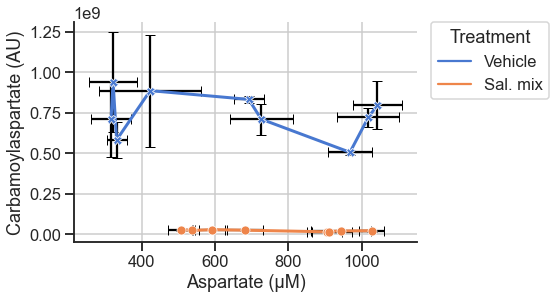

In [14]:
### Carbamoylaspartate as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Carbamoylaspartate neg', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Carbamoylaspartate neg'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Carbamoylaspartate neg'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Carbamoylaspartate (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Carbamoylaspartate.pdf', bbox_inches='tight')

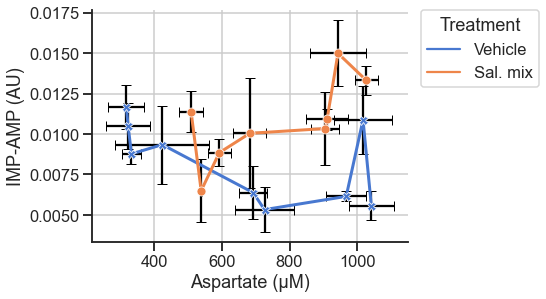

In [15]:
### IMP-AMP as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='IMP-AMP', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['IMP-AMP'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['IMP-AMP'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('IMP-AMP (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-IMP-AMP.pdf', bbox_inches='tight')

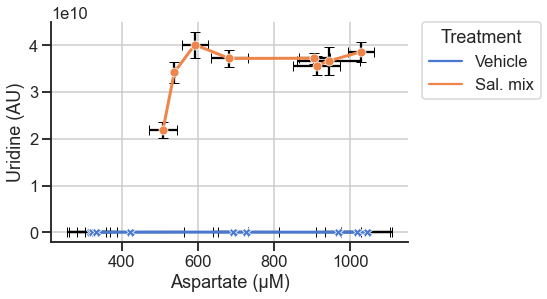

In [16]:
### Uridine as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df_mean['Treatment'] == 'Vehicle') | (df_mean['Treatment'] == 'Sal. mix'))
hue_order = ['Vehicle', 'Sal. mix']
g1 = sns.lineplot(ax=ax1, data=df_mean[mask], x='Aspartate conc', y='Uridine neg', hue='Treatment',
             style='Treatment', hue_order=hue_order, markers=True, dashes=False, linewidth=3, zorder=10)
g1.errorbar(y=df_mean[mask]['Uridine neg'].values, x=df_mean[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Uridine neg'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=1)

g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('Uridine (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig('plots/Aspartate-Uridine.pdf', bbox_inches='tight')

In [70]:
metab_names_mes

['3-Phosphoglycerate neg',
 'Adenosine pos',
 'Alanine pos',
 'alpha-Ketoglutarate neg',
 'AMP pos',
 'Arginine pos',
 'Argininosuccinate neg',
 'Asparagine pos',
 'Aspartate neg',
 'Carbamoylaspartate neg',
 'CMP neg',
 'Cytidine pos',
 'DHAP neg',
 'Fumarate neg',
 'Glucose 6-phosphate neg',
 'Glutamate neg',
 'Glutathione disulfide pos',
 'Glutathione pos',
 'Glycerol 3-phosphate neg',
 'GMP pos',
 'Hypoxanthine pos',
 'IMP pos',
 'Lactate neg',
 'Malate neg',
 'Metformin pos',
 'NAD pos',
 'NADH pos',
 'Ornithine pos',
 'Phosphoenolpyruvate neg',
 'Proline pos',
 'SAICAR neg',
 'SAICAR pos',
 'Serine neg',
 'Succinate neg',
 'UMP neg',
 'Uridine neg',
 'Xanthine neg']

In [11]:
df

,Sample ID,Sample_name,Treatment,Replicate,Metformin,Prlfr,Prlfr_stdev,dilution,3-Phosphoglycerate neg,Adenosine pos,...,Proline pos,SAICAR neg,SAICAR pos,Serine neg,Succinate neg,UMP neg,Uridine neg,Xanthine neg,NAD-NADH,IMP-AMP
0,MT01,MT01,Vehicle,1,0,0.989394,0.006209,0.025,136737240.0,185007480.0,...,18.122419,45620760.0,277832960.0,8.999565,1.814610e+09,0.153553,3.300892e+07,5.395570e+08,70.479237,0.005861
1,MT02,MT02,Vehicle,2,0,0.989394,0.006209,0.025,119411760.0,201730800.0,...,16.203292,56437120.0,262396400.0,9.966540,1.911461e+09,0.155945,3.550920e+07,4.963872e+08,63.440933,0.006469
2,MT03,MT03,Vehicle,3,0,0.989394,0.006209,0.025,137912880.0,264851480.0,...,20.634882,43379160.0,245333200.0,9.878448,1.989450e+09,0.253881,5.763004e+07,5.880204e+08,64.777103,0.006113
3,MT04,MT04,Vehicle,1,50,0.935658,0.005399,0.025,144350920.0,329754200.0,...,22.098747,49412840.0,256399640.0,12.441787,1.971217e+09,0.223925,6.994716e+07,6.243366e+08,64.956862,0.006531
4,MT05,MT05,Vehicle,2,50,0.935658,0.005399,0.025,195671240.0,371001120.0,...,24.172821,25844400.0,247111720.0,14.826653,2.380360e+09,0.334590,7.360572e+07,6.455433e+08,74.884387,0.005410
5,MT06,MT06,Vehicle,3,50,0.935658,0.005399,0.025,193067960.0,414455200.0,...,23.239499,60507360.0,239693720.0,10.440256,2.167261e+09,0.340449,6.962776e+07,6.403828e+08,49.578290,0.004768
6,MT07,MT07,Vehicle,1,100,0.877183,0.011466,0.025,180826720.0,264735720.0,...,15.089969,26874600.0,249141160.0,13.488003,1.770429e+09,0.258138,4.506284e+07,4.626869e+08,72.119477,0.008439
7,MT08,MT08,Vehicle,2,100,0.877183,0.011466,0.025,142883480.0,306133640.0,...,14.108887,48792920.0,226997160.0,13.382185,1.862636e+09,0.264848,4.113152e+07,4.395056e+08,57.309077,0.012232
8,MT09,MT09,Vehicle,3,100,0.877183,0.011466,0.025,180737200.0,336074480.0,...,14.453411,33667280.0,247313640.0,15.105569,1.901741e+09,0.286330,4.299404e+07,4.737816e+08,57.630328,0.011937
9,MT10,MT10,Vehicle,1,200,0.837460,0.009307,0.025,219121880.0,344553880.0,...,35.857796,39276360.0,270416320.0,7.710019,1.956919e+09,0.289924,6.110620e+07,1.034783e+09,61.649569,0.004309


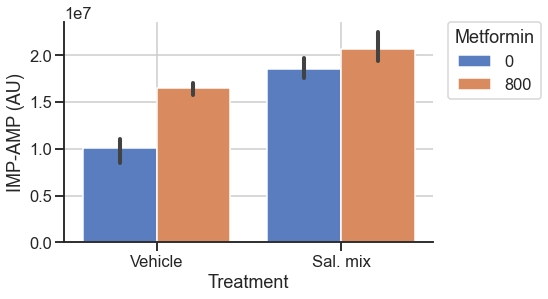

In [17]:
### IMP-AMP as a function of Aspartate ###

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

mask = ((df['Treatment'] == 'Vehicle') | (df['Treatment'] == 'Sal. mix')) & ((df['Metformin'] == 0) | (df['Metformin'] == 800))
hue_order = [0, 800]
g1 = sns.barplot(ax=ax1, data=df[mask], x='Treatment', y='IMP pos', hue='Metformin',
              hue_order=hue_order)

#g1.set_xlabel('Aspartate (μM)')
g1.set_ylabel('IMP-AMP (AU)')

old_legend = g1.legend_
handles = old_legend.legendHandles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()
g1.legend(handles, labels, title=title, bbox_to_anchor=(1.04, 1), borderaxespad=0);

g1.grid(True)
sns.despine()
fig.tight_layout()
#fig.savefig('plots/Aspartate-IMP-AMP.pdf', bbox_inches='tight')